In [1]:
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt

#### Image processing

In [2]:
# Load image and limits dimensions to 512, outputs tf tensor

def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [3]:
# display tf tensor as an image

def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

#### Modified VGG19 Model

In [4]:
# Creates a vgg model that returns a list of intermediate output values

def vgg_layers(layer_names):
    # paper uses avg pooling, exclude fully connected layers since no predictions
    vgg = VGG19(weights='imagenet', include_top=False, pooling = 'avg')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

#### Neural net training

In [5]:
# Image pixel values are from 0 to 1 so define a function that clips value to this range

def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

#### Neural Style Transfer

In [6]:
# Gram matrix

def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

#### Implementation

In [7]:
# Define style and content layers

content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [8]:
# define models

style_model = vgg_layers(style_layers)
content_model = vgg_layers(content_layers)

2022-02-01 18:10:59.297760: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
# load images

style_path = 'style_monetgreen.jpeg'
content_path = 'cat.jpg'

content_img = load_img(content_path)
content_img2 = load_img(content_path)
content_shape = content_img.shape

style_img = load_img(style_path)
style_shape = style_img.shape

In [10]:
# targets for training

content_outputs = content_model(tf.constant(content_img2))
style_targets = style_model(tf.constant(style_img))

style_targets = [gram_matrix(style_output)
                for style_output in style_targets]

In [28]:
# Instead of using a randomly intialized image to be trained on, use the content image for faster training
### Should test later using a randomly intialized image to make sure that the algo still work tho

art = tf.Variable(content_img)

In [12]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [29]:
# weight for loss function

style_weight=1e-2   ### INPUT
content_weight=1e4   ### INPUT

# loss function

def style_content_loss(style_outputs, content_outputs):
    style_loss = tf.reduce_mean((style_outputs-style_targets)**2)
    style_loss *= style_weight / num_style_layers

    content_loss = tf.reduce_mean((content_outputs-content_targets)**2)
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [38]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        style_outputs = style_model(image)
        print("hi")
        style_outputs = tf.convert_to_tensor(style_outputs, dtype=tf.float32)
        print("hi")
        content_outputs = content_model(image)
        content_outputs = tf.convert_to_tensor(content_outputs, dtype=tf.float32)
        
        print("hi")
        
        loss = style_content_loss(style_outputs, content_outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))
    
    return loss

In [49]:
img = load_img('cat.jpg')
img_shape = img.shape

In [50]:
s1 = style_model(img)

In [51]:
layers = ['block1_conv1']   ### INPUT

new_model = vgg_layers(layers)
targets = new_model(tf.constant(img))

list

In [47]:
style_outputs = style_model(art)
print(type(style_outputs))
style_outputs = tf.convert_to_tensor(style_outputs)

<class 'list'>


InvalidArgumentError: Shapes of all inputs must match: values[0].shape = [1,320,512,64] != values[1].shape = [1,160,256,128] [Op:Pack] name: packed

In [39]:
train_step(art)

hi


ValueError: in user code:

    /var/folders/vx/v8_qvy9d6v331m2fzrp2g40m0000gn/T/ipykernel_98602/162623036.py:6 train_step  *
        style_outputs = tf.convert_to_tensor(style_outputs, dtype=tf.float32)
    /Users/DRRRR/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper  **
        return target(*args, **kwargs)
    /Users/DRRRR/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1405 convert_to_tensor_v2_with_dispatch
        value, dtype=dtype, dtype_hint=dtype_hint, name=name)
    /Users/DRRRR/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1415 convert_to_tensor_v2
        as_ref=False)
    /Users/DRRRR/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/profiler/trace.py:163 wrapped
        return func(*args, **kwargs)
    /Users/DRRRR/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1540 convert_to_tensor
        ret = conversion_func(value, dtype=dtype, name=name, as_ref=as_ref)
    /Users/DRRRR/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/array_ops.py:1525 _autopacking_conversion_function
        return _autopacking_helper(v, dtype, name or "packed")
    /Users/DRRRR/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/array_ops.py:1461 _autopacking_helper
        return gen_array_ops.pack(elems_as_tensors, name=scope)
    /Users/DRRRR/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/gen_array_ops.py:6398 pack
        "Pack", values=values, axis=axis, name=name)
    /Users/DRRRR/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:750 _apply_op_helper
        attrs=attr_protos, op_def=op_def)
    /Users/DRRRR/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/func_graph.py:592 _create_op_internal
        compute_device)
    /Users/DRRRR/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:3536 _create_op_internal
        op_def=op_def)
    /Users/DRRRR/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:2016 __init__
        control_input_ops, op_def)
    /Users/DRRRR/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1856 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimension 1 in both shapes must be equal, but are 40 and 20. Shapes are [1,40,64,512] and [1,20,32,512].
    	From merging shape 3 with other shapes. for '{{node packed}} = Pack[N=5, T=DT_FLOAT, axis=0](model/block1_conv1/Relu, model/block2_conv1/Relu, model/block3_conv1/Relu, model/block4_conv1/Relu, model/block5_conv1/Relu)' with input shapes: [1,320,512,64], [1,160,256,128], [1,80,128,256], [1,40,64,512], [1,20,32,512].


#### Implementation

In [8]:
# Load image

   ### INPUT

img = load_img(img_path)
img_shape = img.shape

2022-01-28 12:03:47.189869: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
sd = 0   ### INPUT

random = tf.random.Generator.from_seed(sd) # an instance of the generator class
random_init = random.uniform(minval=0, maxval=1, shape=content_shape) # shape matches the content_image
print(type(random_init))
print(type(content_img))

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


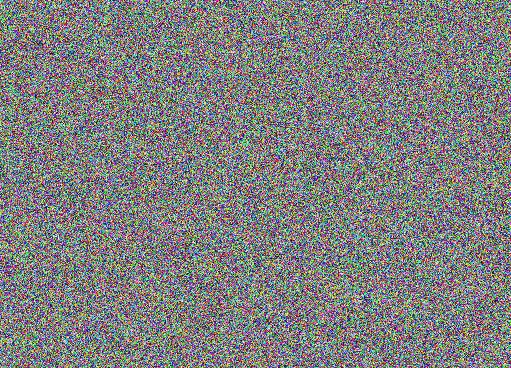

In [10]:
# create randomly intialized image, which would be trained on to revisualize the designated layer

sd = 0   ### INPUT

random = tf.random.Generator.from_seed(sd) # an instance of the generator class
random_init = random.uniform(minval=0, maxval=1, shape=img_shape) # shape matches the content_image
print
visualization = tf.Variable(random_init)

tensor_to_image(random_init)

In [11]:
opt = tf.optimizers.Adam(learning_rate=1, beta_1=0.99, epsilon=1e-1)

In [12]:
# train setup

loss_threshold = 0.01   ### INPUT
step = 0
loss_list = []

In [14]:
# train (re-run this section for continuous training)

loss_threshold = 0.01   ### INPUT

loss = train_step(visualization)
while loss > loss_threshold:
    loss = train_step(visualization)
    step += 1
    loss_list.append(loss)
    if step % 100 == 0:
        print(f'{step}: {loss.numpy()}')

600: 0.10383997112512589
700: 0.10291673988103867
800: 0.10195605456829071


KeyboardInterrupt: 

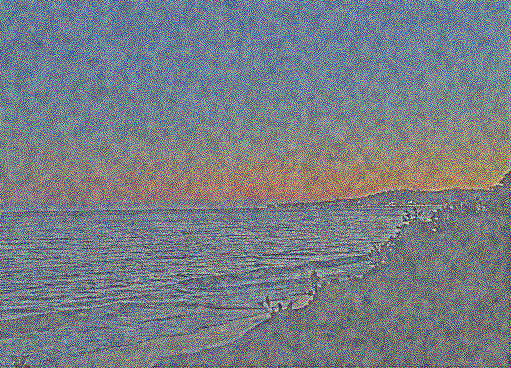

In [111]:
tensor_to_image(visualization)